<a href="https://colab.research.google.com/github/monica1234van/RLScheduleProject/blob/main/COGS182ScheduleProject_Checkpoint3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 182 Project 2 | Schedule Optimization

## Checkpoint 3: Implementing the Algorithms


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits import mplot3d 
import seaborn as sns
from tqdm.auto import tqdm
import pickle

#### List of Possible Topics & Actions (Hour Allocations to Each Topic) & Resultant States

In [ ]:
possible_topics=['topology', 
                 'Japanese', 
                 'webtooning',
                 'physics', 
                 'video-editing', 
                 'graphic design', 
                 'animation', 
                 'psych/linguistics', 
                 'R/statistical packages', 
                 'front-end coding']

#0-12 = allot hrs, 7 = commit to schedule    
possible_actions = [0,1,3,5,7]

In [ ]:
r_times = []
for remaining_time in np.arange(25):
    for action in [0,1,3,5]:
        for org_hrs in [0,1,2,3,4]:
            for lab_hrs in [0, 1,2]:
                r_time = remaining_time - action - org_hrs - lab_hrs
                r_times.append(r_time)
                
possible_remaining_times = sorted(np.unique(r_times))


terminal_states = []
for r_time in possible_remaining_times:
    terminal_state = [r_time, 0]
    terminal_states.append(terminal_state)

possible_states = [0]   
for r_time in possible_remaining_times:
        for len_schedule in np.arange(len(possible_topics) +1):
            for topic in possible_topics:
                state = [r_time, len_schedule, topic]
                if state[0] > 0:
                    possible_states.append(state)
        
# len(terminal_states),len(possible_states)

pos_states = [0]
for state_indx, state in enumerate(possible_states[1:]):
    r_time, len_schd, topic = state
    no_topic_state = [r_time, len_schd]
    if no_topic_state not in pos_states:
        pos_states.append(no_topic_state)

#### Factors (i.e. schedule fulfillment, coherence) to take into account when calculating the rewards

In [ ]:
#mutually reinforcing subjects (not really accurate to real life, but it suffices)
related_topics = {'topology': ['physics', 'R/statistical packages', 'graphic design'],
                    'Japanese': ['linguistics', 'animation', 'webtooning'],
                    'webtooning': ['animation', 'Japanese', 'graphic design'],
                    'physics': ['topology','chemistry', 'R/statistical packages'],
                    'video-editing': ['animation', 'content creation', 'webtooning'],
                    'graphic design': ['webtooning', 'front-end coding'],
                    'animation': ['webtooning', 'video-editing', 'graphic design', 'content creation'],
                    'psych/linguistics': ['Japanese', 'R/statistical packages'],
                    'R/statistical packages': ['educational psychology', 'physics'],
                    'front-end coding': ['graphic design', 'animation', 'content creation']}

# personal ratings of [frustration/learning curve, intrigue, applicability] by topic
fulfillment_factors = {'topology': [1, 1, 0.6],
                       'Japanese': [0.7, 1, 1],
                        'webtooning': [0.5, 0.5, 0.4],
                        'physics': [1, 0.9, .6],
                        'video-editing': [0.8, 0.4, 1],
                        'graphic design': [0.5, 0.3, 0.6],
                        'animation': [1, 0.9, 0.7],
                        'psych/linguistics': [0.6, 0.7, 0.7],
                        'R/statistical packages': [0.5, 0.4, 1],
                        'front-end coding': [0.6, 0.7, 1]}
fulfillment_scores = {}
for topic in fulfillment_factors:
    frustration, intrigue, applicability = fulfillment_factors[topic]
    
    #fulfillment factors scale positive rewards 
    fulfillment_score = (0.25*frustration + 0.5*intrigue + 0.25*applicability)
    fulfillment_scores[topic] = fulfillment_score

#### Step function, take in remaining time (in a day), the schedule, the topic of consideration, and the action
* NOTE: for feasibility sake, the observed state is actually only the LENGTH of the current schedule, but the entire schedule is passed for the environment to do calculations

In [ ]:
# state keeps track of remaining free time in a day, the length of the schedule, and the current topic 
    # length of schedule instead of actual schedule, since that's too many different states... 

def step(remaining_time, schedule, topic, action):
    
    state = [remaining_time, len(schedule)]
    state_indx = pos_states.index(state)
    
    if action != 7:
        if action != 0:
            remaining_time -= action 
            schedule[topic] = action #then allot hours according to a policy?            

        topic = np.random.choice(possible_topics)
        new_state = [remaining_time, len(schedule)]
        reward = 0
        

        if remaining_time < 6:
            # print("\033[1;31m  KAROSHI  \033[0m YOU DIED OF OVERWORK")
            # sys.stdout.flush()
            reward = -1
            new_state = 0
        
        return new_state, reward, schedule, topic
    
    
    # ENVIRONMENT GOES when commit to schedule
    elif action == 7:        
        new_state, reward, schedule, remaining_time = env(remaining_time, schedule)

        return new_state, reward, schedule, remaining_time 

#### When the environment goes,
it takes the remaining time and schedule, adds on random hours from existing commitments, calculates if the remaining time in a day allows for sleep, calculates the schedule fulfillment and modulates the fulfillment with bonuses for schedule coherence and having enough to sleep. The terminal state is returned [remaining_time, 0].

In [ ]:
def env(remaining_time, schedule):
    
        existing_commitments = {'Orgs': np.random.choice(np.arange(1,5)), 'LabStuff': np.random.choice(np.arange(1,3))}
    # factor in existing commitments 
        remaining_time -= (existing_commitments['Orgs'] + existing_commitments['LabStuff'])

        # KAROSHI AGAIN if forget about current commitments 
        if remaining_time < 6:             
            reward = -1
        
        #penalty for undercommitment (listlessness)
        elif remaining_time > 18: 
            reward = -0.5
        
        else: 
            total_fulfillment = 0 

            # get average of fulfillments of all commitments in schedule
            for topic in schedule:
                if topic in ["Orgs", "LabStuff"]:
                    continue
                else:
                    total_fulfillment += fulfillment_scores[topic]
            total_fulfillment = np.mean(total_fulfillment)

            # factor in related subjects into fulfillment score (mutually reinforcing)
            # if too many subjects at once, coherence turns into distraction factor, negative rate
            coherence = 1
            if len(schedule) <= 3:
                for topic in schedule:
                    for possible_topic in possible_topics:
                        if topic == possible_topic:
                            for related_topic in related_topics[topic]:
                                if related_topic in schedule:
                                    coherence += 0.05    
            elif len(schedule) > 4: #too many topics
                coherence = -0.5

            # sleep and free time bonus (a rate)
            if remaining_time >= 8 and remaining_time <= 10:
                bonus = 1.1          # 10% bonus fulfillment
            else: 
                bonus = 1            # no bonus
                

            # reward to return as a function of bonus, topic-based fulfillment and coherence of schedule
            reward = (total_fulfillment)* ((bonus + coherence)/ 2)  

        schedule['Orgs'] = existing_commitments['Orgs'] 
        schedule['LabStuff'] = existing_commitments['LabStuff']
        
        new_state = 0
        
        return new_state, reward, schedule, remaining_time

___________
## Algorithm 1: On-Policy First-Visit Monte Carlo Control

In [ ]:
def init_q_values(init):
    if init == "zeros":
        q_values = np.zeros((len(pos_states), len(possible_actions)))  
    elif init == 'arb':
        q_values = np.ones((len(pos_states), len(possible_actions)))
        for indx, value in enumerate(q_values):
            q_values[indx] = np.random.rand()
    else: 
        q_values = np.ones((len(pos_states), len(possible_actions))) * init
    return q_values

In [ ]:
def MonteCarlo(init, num_runs):
    # num of times that action a has been selected from state s
    N = np.zeros((len(pos_states), len(possible_actions)))
    N_0 = 1

    # hyperparameters
    gamma = 0.5    # discount factor - balance between being too myopic (0) and too farsighted (1)
    epsilon = N_0/(N_0 + 0) 

    # initialize policy, q_values, returns

    q_values = init_q_values(init)
    returns = np.zeros((len(pos_states), len(possible_actions)))
    policy = np.ones((len(pos_states), len(possible_actions))) * (epsilon/len(possible_actions)) 

    all_episodes = []
    all_episode_rewards = []

    for run in tqdm((range(num_runs)), position=0):

        remaining_time = 24
        schedule = {}
        topic = np.random.choice(possible_topics)

        state      = [remaining_time, len(schedule)]                   
        state_indx = pos_states.index(state)

        action = np.random.choice(possible_actions, p= policy[state_indx])

        episode = []
        episode_rewards = []

        while True:        
            if action != 7:
                new_state, reward, schedule, topic = step(remaining_time, schedule, topic, action)
            elif action == 7:
                new_state, reward, schedule, remaining_time = step(remaining_time, schedule, topic, action)
            
            ep = [state, action, reward, schedule]
            episode.append(ep)
            episode_rewards.append(reward)

            if new_state == 0:
                break

            remaining_time, len_schedule = new_state
            state = [remaining_time, len_schedule]
            state_indx = pos_states.index(state)

            action = np.random.choice(possible_actions, p= policy[state_indx])     
            action_indx = possible_actions.index(action)

        all_episodes.append(episode)
        all_episode_rewards.append(episode_rewards)

        G = 0
        #loop through episode in reverse
        for indx_rev, state_action in enumerate(episode[::-1]):
            state, action, reward, schedule = state_action
            state_indx = pos_states.index(state)
            action_indx = possible_actions.index(action)

            indx_state_action = len(episode_rewards) - indx_rev -1 

            G += gamma*G + episode_rewards[indx_state_action]
            returns[state_indx][action_indx] = G


            if state_action not in episode[:indx_state_action]:
                N[state_indx][action_indx] += 1
                alpha = 1/(N[state_indx][action_indx]) # use time-varying alpha  
                q_values[state_indx][action_indx] +=  alpha * (G - q_values[state_indx][action_indx])
                epsilon = N_0/(N_0 + np.min(N[state_indx][action_indx]))  # epsilon-greedy exploration strategy 

                #update policy
                optimal_action = np.argmax(q_values[state_indx])
                for action_indx in range(len(possible_actions)):
                    if action_indx == optimal_action:
                        policy[state_indx][action_indx] = 1 - epsilon + (epsilon/ len(possible_actions))
                    elif action_indx != optimal_action:
                        policy[state_indx][action_indx] = (epsilon/ len(possible_actions))

    return policy, q_values, all_episodes, all_episode_rewards

In [ ]:
def quick_check(q_values, policy):
    #quick check of Q-values vs. policy
    
    print("<<QUICK CHECKS>>")
    oops = [100, 150, 200, 250]
    
    for oop in oops:
        print("----------------------")
        print("state:", pos_states[oop], "\nQs:", q_values[oop],"\nPi:", policy[oop])
        print("Q says", np.argmax(q_values[oop]), "| Pi says", np.argmax(policy[oop]))
    
    agreements = 0
    for state_indx, state in enumerate(pos_states):
        if np.argmax(q_values[state_indx]) ==  np.argmax(policy[state_indx]):
            agreements += 1
    print("Policy aligns with Q-values:", agreements / len(pos_states) * 100, "%")                                 
                                                         
    sys.stdout.flush()   

In [ ]:
def get_opt_actions(policy):
    
    
    if algo == "MC":
        optimal_actions = []
        for state_indx, state in enumerate(pos_states):
            action_indx = np.argmax(policy[state_indx])
            if action_indx == 0:
                action = 0
                optimal_actions.append(action)
            elif action_indx == 1:
                action = 1
                optimal_actions.append(action)
            elif action_indx == 2:
                action = 3
                optimal_actions.append(action)
            elif action_indx == 3:
                action = 5
                optimal_actions.append(action)
            elif action_indx == 4:
                action = 7
                optimal_actions.append(action)
        
    return optimal_actions

In [ ]:
def calc_V_star(q_values):
    #calculate optimal value function V_star
    V_star = []
    for state_indx in range(len(pos_states)):
        optimal_value = np.max(q_values[state_indx])
        V_star.append(optimal_value)
    len(V_star)
    V_star = np.array(V_star)
    
    return V_star

In [ ]:
def plot_values_actions_states(algo, values_or_qvalues):
    if algo == "MC":
        V_star = calc_V_star(values_or_qvalues)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        ax[0].plot(np.argmax(values_or_qvalues, axis=0),["0","1","3","5","commit"], "-o")
        ax[0].set_xlabel("State Index (Remaining Hours Increase with State Index)")
        ax[0].set_ylabel("Optimal Action")
        ax[0].set_title("Optimal Action Trends per State Index")

        ax[1].plot(V_star, '-o')
        ax[1].set_ylabel("Values")
        ax[1].set_xlabel("State Index (Remaining Hours Increase with State Index)")
        ax[1].set_title("Values vs. State Index")

    elif algo == "TD":
        plt.plot(values_or_qvalues, '-o')
        plt.ylabel("Values")
        plt.xlabel("State Index (Remaining Hours Increase with State Index)")
        plt.title("Values vs. State Index")
        
    plt.show()

In [ ]:
def plot_heatmap(V_star):
    
    x = np.linspace(0, 24, 25) #remaining times
    y = np.linspace(0, 10, len(possible_topics)) #possible schedule lengths
    X, Y = np.meshgrid(x, y)
    Z = np.ones((25, len(possible_topics)))

    for state_indx, state in enumerate(pos_states[1:]):
        r_time, len_schd = state
        value = V_star[state_indx]
        Z[r_time - 1][len_schd - 1] = value
        
    fig = plt.figure(figsize =(14, 9))
    ax = sns.heatmap(Z, linewidth=0.5, annot=True)
    plt.xlabel("Schedule Length (# topics before orgs/lab)")
    plt.ylabel("Remaining Time (hrs)")
    plt.title("Max Value per State")

    plt.xlim(0,)
    plt.ylim(0,24)
    plt.show()

    # x.shape,y.shape, Z.shape

In [ ]:
def get_opt_schedules(V_star, all_episodes, optimal_actions):
    optimal_schedules = []
    part_optimal_schedules =  []
    
    optimal_schd_rewards = []
    part_opt_schd_rewards = []
    
    for state_indx, action in enumerate(optimal_actions):
        if action == 7:

            for episode in all_episodes:
                state, action, reward, schedule = episode[-1]
                
                if len(schedule) > 2 and "LabStuff" in schedule:
                    if state == pos_states[np.argmax(V_star)]:
                        optimal_schedules.append(schedule)
                        optimal_schd_rewards.append(reward)
    
                    elif state[0] == pos_states[np.argmax(V_star)][0] or state[1] == pos_states[np.argmax(V_star)][1]:
                        part_optimal_schedules.append(schedule)
                        part_opt_schd_rewards.append(reward)

    return optimal_schedules, part_optimal_schedules, optimal_schd_rewards, part_opt_schd_rewards

###  Run Monte Carlo using different Initializations

INIT Q-VALUES AS -0.1:  



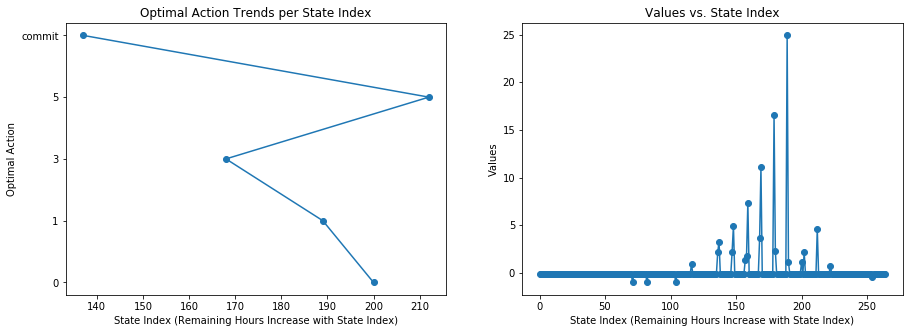

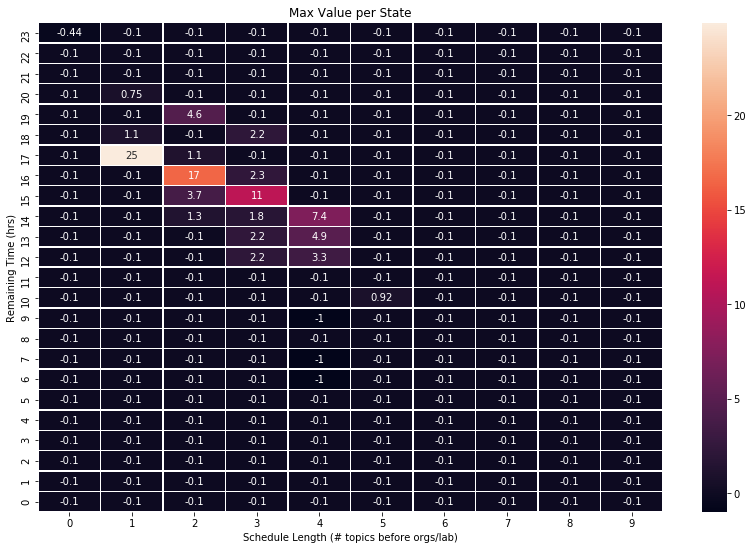

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 18 HOURS 
Optimal Schedule Length: 1 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
Partially Optimal Schedules:
{'Orgs': 3, 'webtooning': 3, 'LabStuff': 1} | Fulfillment: 0.9
{'Orgs': 4, 'topology': 5, 'LabStuff': 1} | Fulfillment: 1.15
{'Orgs': 1, 'topology': 5, 'LabStuff': 1} | Fulfillment: 0.875
{'Orgs': 4, 'animation': 3, 'LabStuff': 2} | Fulfillment: 0.9
{'Orgs': 2, 'webtooning': 1, 'psych/linguistics': 5, 'LabStuff': 2} | Fulfillment: 0.9
{'animation': 5, 'Orgs': 1, 'LabStuff': 2} | Fulfillment: 0.475
{'Orgs': 4, 'R/statistical packages': 5, 'LabStuff': 1} | Fulfillment: 0.875
{'Orgs': 2, 'LabStuff': 2, 'topology': 3} | Fulfillment: 0.575
---------------------------------------

INIT Q-VALUES AS 0.1:  



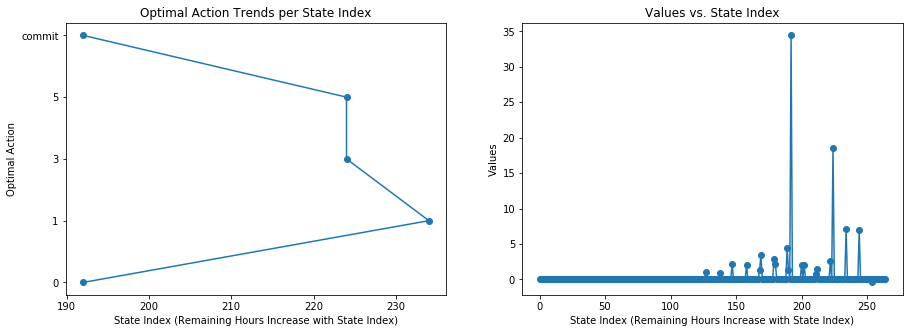

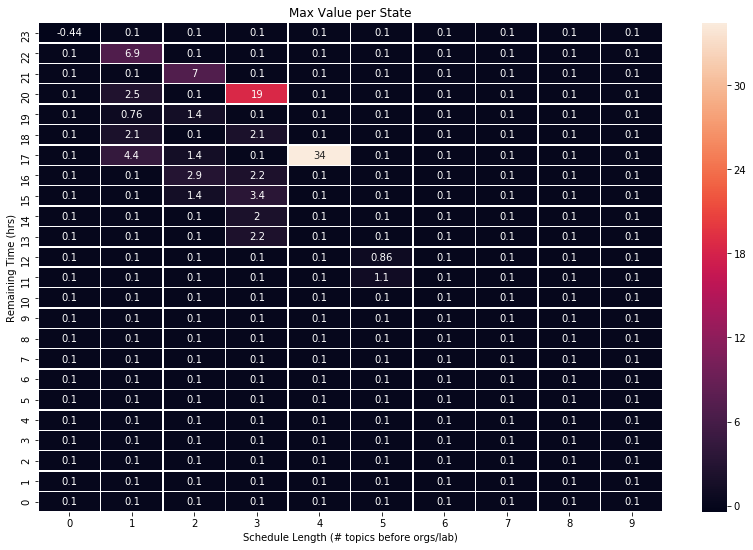

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 18 HOURS 
Optimal Schedule Length: 4 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
{'Japanese': 3, 'LabStuff': 1, 'topology': 1, 'Orgs': 3, 'R/statistical packages': 1, 'physics': 1} | Fulfillment: 3.25
---------------------------------------

INIT Q-VALUES AS zeros:  



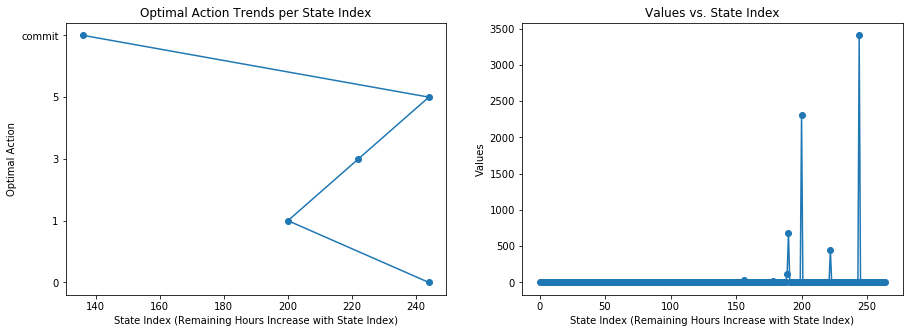

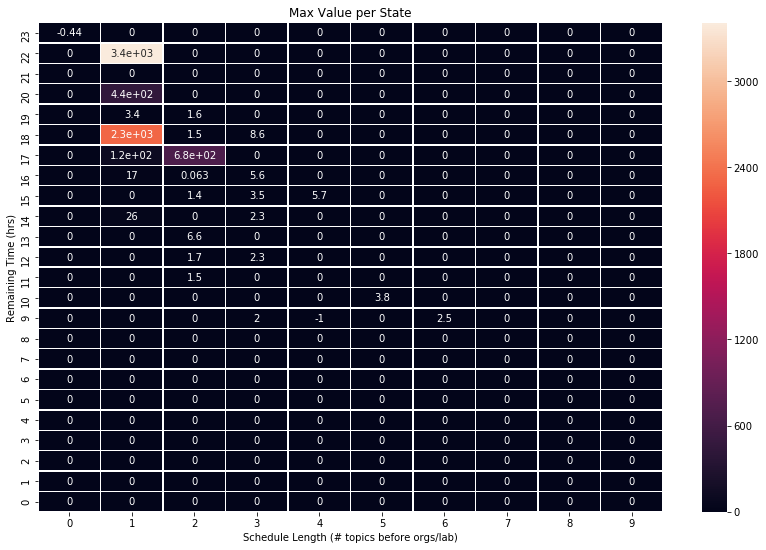

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 23 HOURS 
Optimal Schedule Length: 1 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
{'LabStuff': 1, 'Orgs': 2, 'Japanese': 1} | Fulfillment: -0.5
{'topology': 1, 'Orgs': 2, 'LabStuff': 2} | Fulfillment: -0.5
---------------------------------------

INIT Q-VALUES AS arb:  



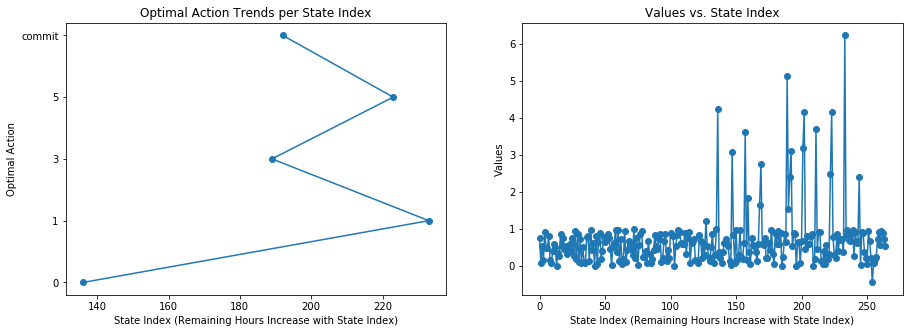

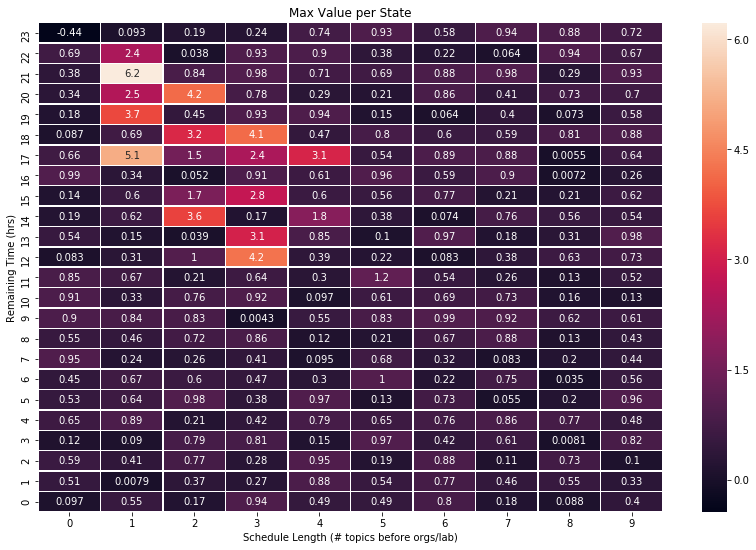

PRIOR TO ORGS/LABSTUFF:
Optimal Remaining Time: 22 HOURS 
Optimal Schedule Length: 1 COMMITMENTS

WITH ORGS/LABS IN FINAL CONSIDERATION
Optimal Schedules:
{'graphic design': 1, 'Orgs': 1, 'LabStuff': 1} | Fulfillment: -0.5
---------------------------------------

CPU times: user 1min 58s, sys: 4.23 s, total: 2min 2s
Wall time: 1min 58s


In [ ]:
%%time 

num_runs = 100000
#try with different initialization of q_values
inits = [-0.1, 0.1,'zeros', 'arb']

policies = []
MC_init_qs = []
MC_init_eps = []
MC_init_ep_rewards = []
MC_init_opt_actions = []


for init in inits:
    print("\033[1;31mINIT Q-VALUES AS {}:  \033[0m\n".format(init))
    
    policy, q_values, all_episodes, all_episode_rewards = MonteCarlo(init, num_runs)
    optimal_actions = get_opt_actions(policy)
    
    policies.append(policies)
    MC_init_qs.append(q_values)
    MC_init_eps.append(all_episodes)
    MC_init_ep_rewards.append(all_episode_rewards)
    MC_init_opt_actions.append(optimal_actions)
    print()
    
#     quick_check(q_values,policy)
#     print()
#     for action in possible_actions:
#         if action != 7:
#             print("optimal to allot",action, "hrs:", optimal_actions.count(action), "x")
#         else:
#             print("Optimal to commit:     ", optimal_actions.count(action), "x")
#     print()
    
    #calculate V_star & Plots
    V_star = calc_V_star(q_values)
    plot_values_actions_states("MC", q_values)
    plot_heatmap(V_star)
    best_r_time, best_len = pos_states[np.argmax(V_star)]
    print("PRIOR TO ORGS/LABSTUFF:")
    print("Optimal Remaining Time: {} HOURS \nOptimal Schedule Length: {} COMMITMENTS".format(best_r_time, best_len))
    print()
    
    # returns schedules that are EITHER the optimal length or optimal, get unique entries
    optimal_schedules, part_optimal_schds, opt_schd_rewards, part_opt_rewards = get_opt_schedules(V_star, all_episodes, optimal_actions)
    optimal_schedules = [dict(entry) for entry in set(frozenset(schd.items()) for schd in optimal_schedules)]
    part_optimal_schds = [dict(entry) for entry in set(frozenset(schd.items()) for schd in part_optimal_schds)]
    
    print("WITH ORGS/LABS IN FINAL CONSIDERATION")
    print("Optimal Schedules:")
    for indx, schd in enumerate(optimal_schedules):
        
        print(schd, "| Fulfillment:", opt_schd_rewards[indx])
        
    
    if optimal_schedules == []:
        print("Partially Optimal Schedules:")
        for indx, schd in enumerate(part_optimal_schds):
            print(schd, "| Fulfillment:", part_opt_rewards[indx])
            
    
    print("---------------------------------------\n")
    sys.stdout.flush()

In [ ]:
with open('MC_policies.pickle', 'wb') as mc_results1:
    pickle.dump(policies, mc_results1)
with open('MC_init_qs.pickle', 'wb') as mc_results2:
    pickle.dump(MC_init_qs, mc_results2)
with open('MC_init_eps.pickle', 'wb') as mc_results3:
    pickle.dump(MC_init_eps, mc_results3)
with open('MC_init_ep_rewards.pickle', 'wb') as mc_results4:
    pickle.dump(MC_init_ep_rewards,mc_results4)                  
with open('MC_init_opt_actions.pickle', 'wb') as mc_results5:
    pickle.dump(MC_init_opt_actions, mc_results5)                 

___________
# Algorithm 2: TD($\lambda$)

![image.png](attachment:image.png)

In [ ]:
# epsilon-greedy policy 
def epsilon_greedy(epsilon, values, state):
    state_indx = pos_states.index(state)
    be_greedy = (np.random.random() > epsilon)
    if be_greedy:
        action = np.argmax(values[state_indx]) #optimal action
    else:
        action = np.random.choice(possible_actions) 
    return action

In [ ]:
# # initialize V(s) 
def init_values(init):
    if init == "zeros":
        values = np.zeros((len(pos_states)))
    elif init == 'arb':
        values = np.ones((len(pos_states)))
        for state_indx,state in enumerate(pos_states):
            if state in terminal_states:
                values[state_indx] = 0
            else:
                values[state_indx] = np.random.random()
    else: 
        values = np.ones((len(pos_states))) * init
    return values

In [ ]:
def TD(init, lmbda, num_eps):
    # initialize V(s) arbitrarily but set to 0 if state is terminal
    values = init_values(init)

    all_episodes = []
    all_episode_rewards = []

    for episode in tqdm(range(num_eps)):

        #initialize weights
        e_weights = np.zeros(len(pos_states))

        #initialize S
        remaining_time = 24
        schedule = {}
        topic = np.random.choice(possible_topics)

        state      = [remaining_time, len(schedule)]
        state_indx = pos_states.index(state)

        episode = []
        episode_rewards = []
        
        # for each step in episode
        while True:
            #take action, observe reward, new_state
            action = epsilon_greedy(epsilon, values, state) 
            action_indx = possible_actions.index(action)

            if action == 7:
                new_state, reward, schedule, remaining_time = step(remaining_time, schedule, topic, action)
                new_state_indx  = pos_states.index(new_state)
            elif action != 7:
                new_state, reward, schedule, topic = step(remaining_time, schedule, topic, action)
                new_state_indx  = pos_states.index(new_state)
                
            ep = [state, action, reward, schedule]
            episode.append(ep)
            episode_rewards.append(reward)

            # update error and weights
            td_error             = reward + gamma*values[new_state_indx] - values[state_indx]
            e_weights[state_indx]= (1 - alpha) * e_weights[state_indx]  + 1 #dutch traces

            #update values and eligibility weights for all states
            values               = values + alpha * td_error * e_weights
            e_weights            = gamma * lmbda * e_weights

            if new_state == 0:
                break

            remaining_time, len_schedule  = new_state
            state = [remaining_time, len_schedule]
            state_indx = pos_states.index(state) 
            
    
    all_episodes.append(episode)
    all_episode_rewards.append(episode_rewards)

    return values, all_episodes, all_episode_rewards

  INIT VALUES as 0.1 
  LAMBDA = 0 


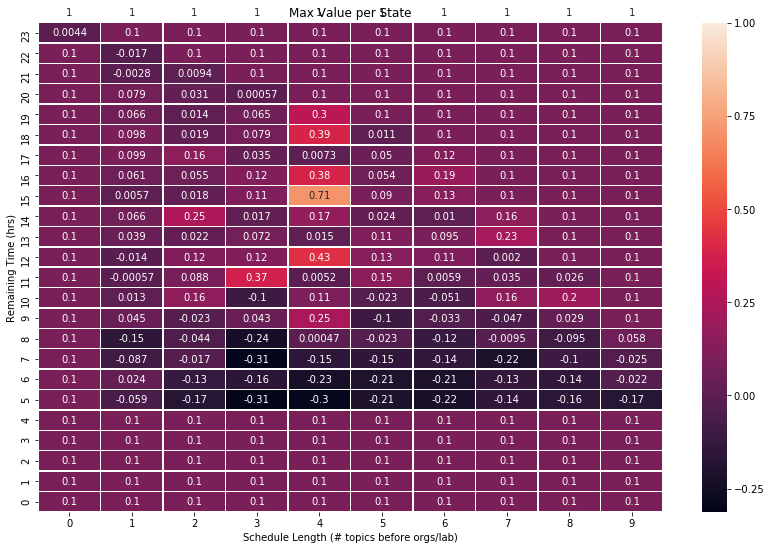

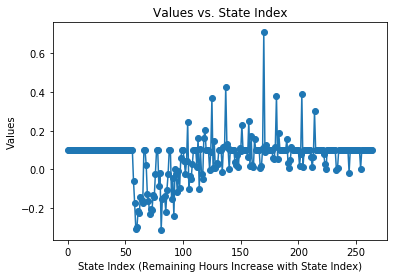

PRIOR TO ORGS/LAB:
Optimal Free Time: 16 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


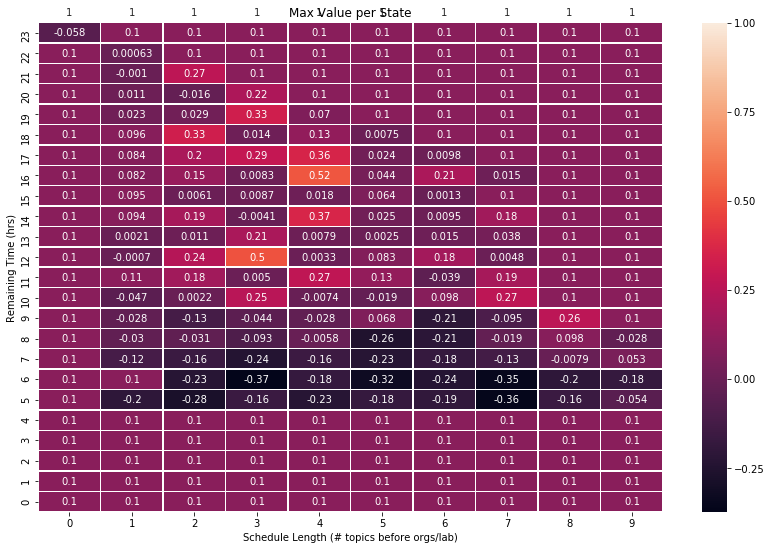

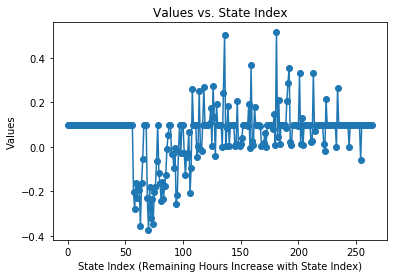

PRIOR TO ORGS/LAB:
Optimal Free Time: 17 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


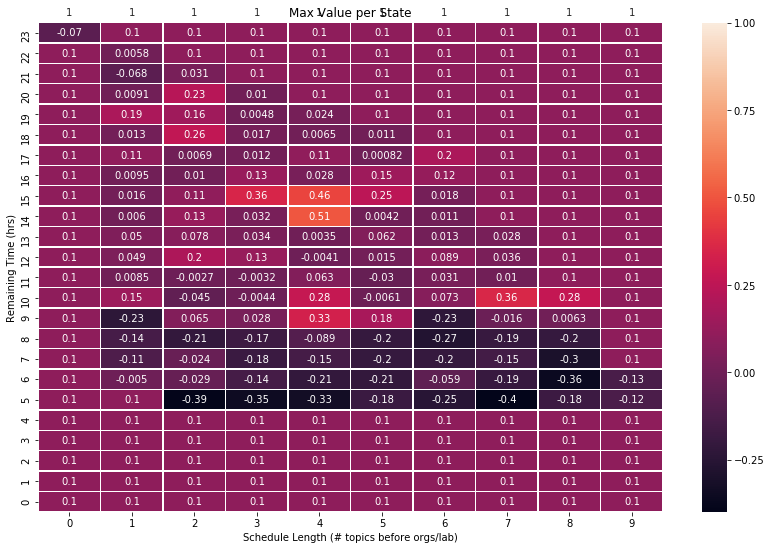

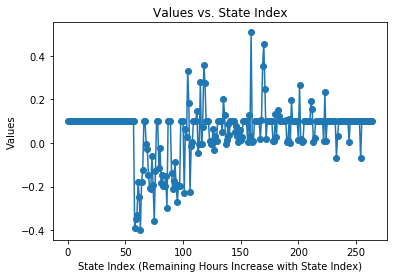

PRIOR TO ORGS/LAB:
Optimal Free Time: 15 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


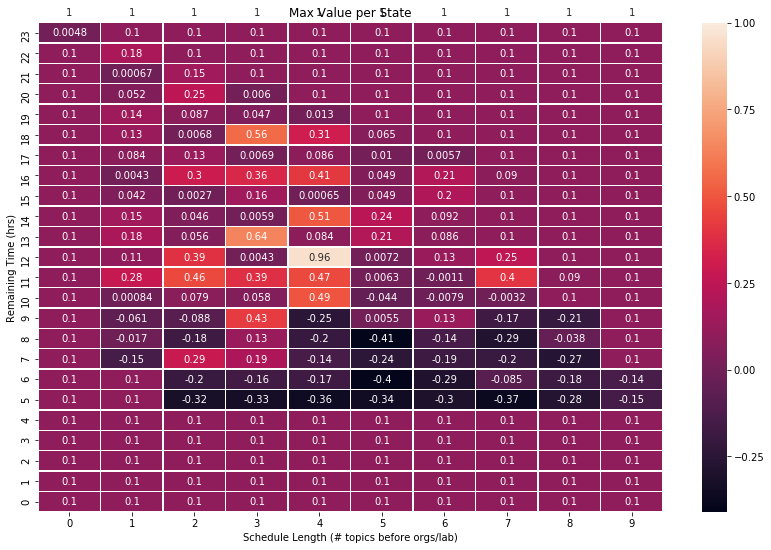

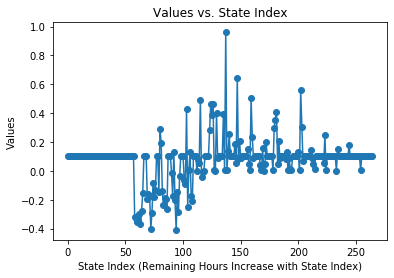

PRIOR TO ORGS/LAB:
Optimal Free Time: 13 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  INIT VALUES as arb 
  LAMBDA = 0 


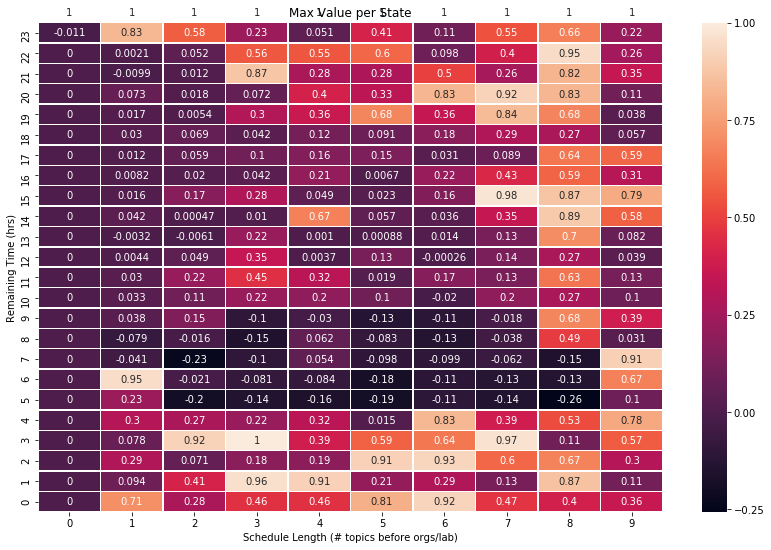

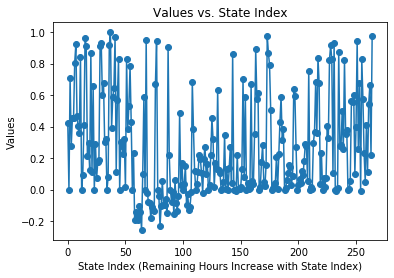

PRIOR TO ORGS/LAB:
Optimal Free Time: 4 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


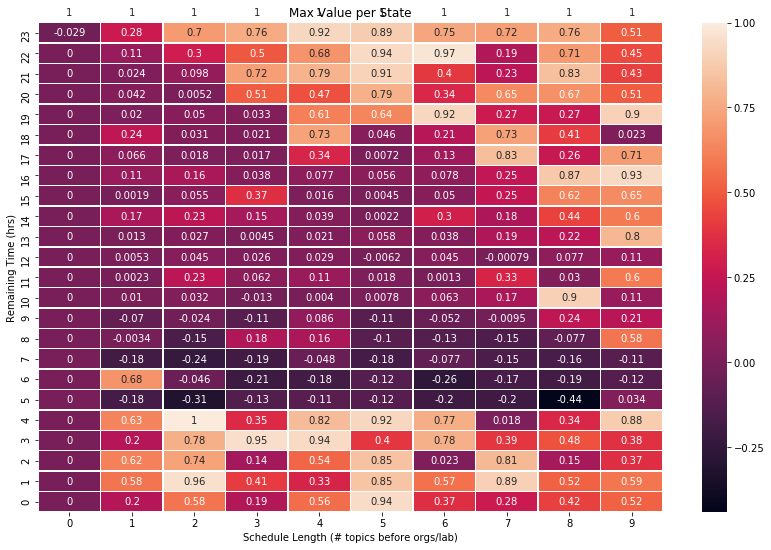

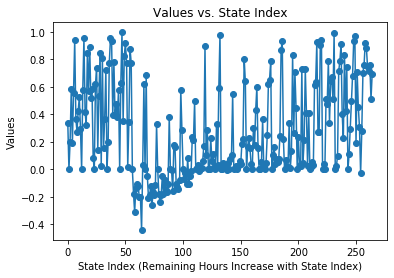

PRIOR TO ORGS/LAB:
Optimal Free Time: 5 HOURS 
Optimal Schedule Length (without Orgs/Lab): 2 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


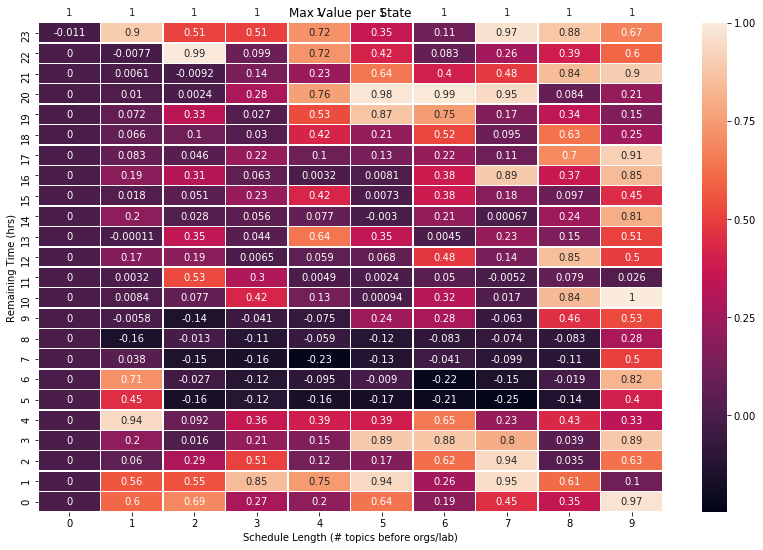

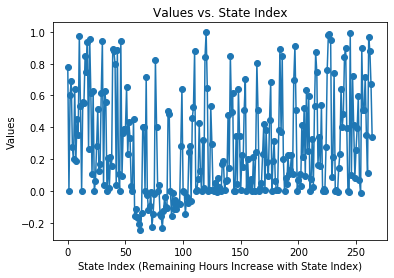

PRIOR TO ORGS/LAB:
Optimal Free Time: 11 HOURS 
Optimal Schedule Length (without Orgs/Lab): 9 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


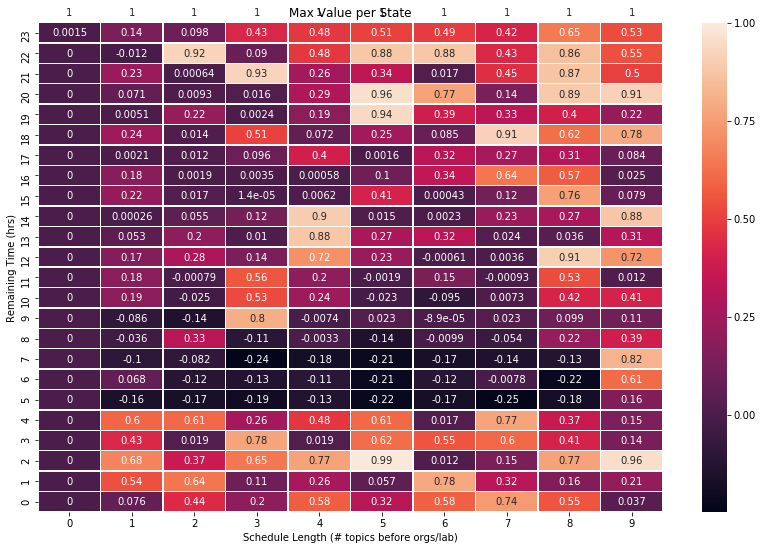

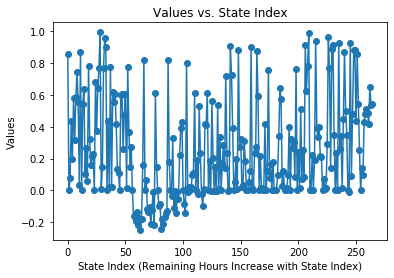

PRIOR TO ORGS/LAB:
Optimal Free Time: 3 HOURS 
Optimal Schedule Length (without Orgs/Lab): 5 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  INIT VALUES as zeros 
  LAMBDA = 0 


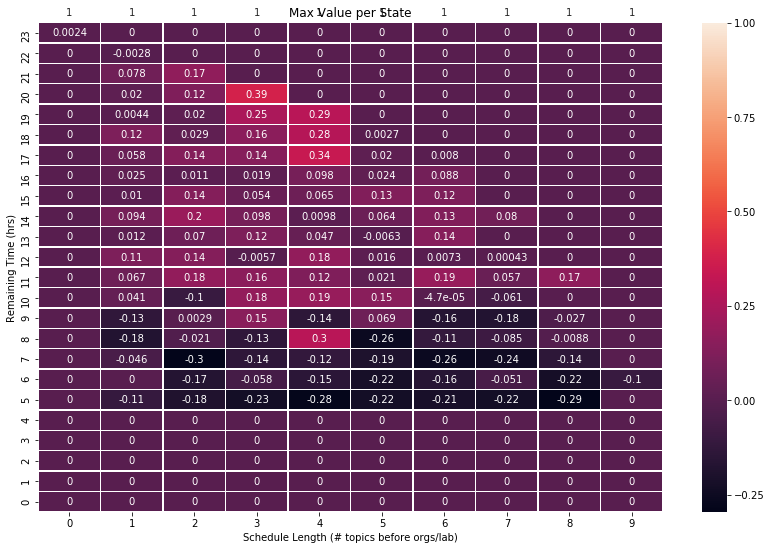

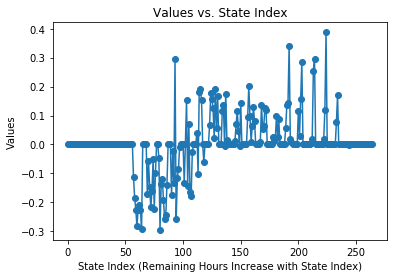

PRIOR TO ORGS/LAB:
Optimal Free Time: 21 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.5 


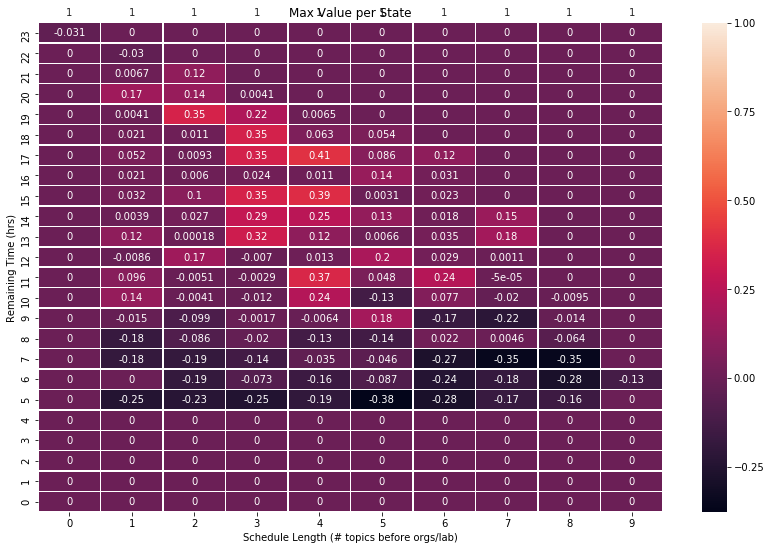

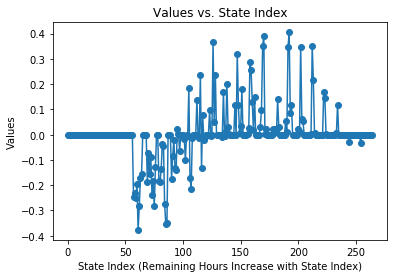

PRIOR TO ORGS/LAB:
Optimal Free Time: 18 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 0.75 


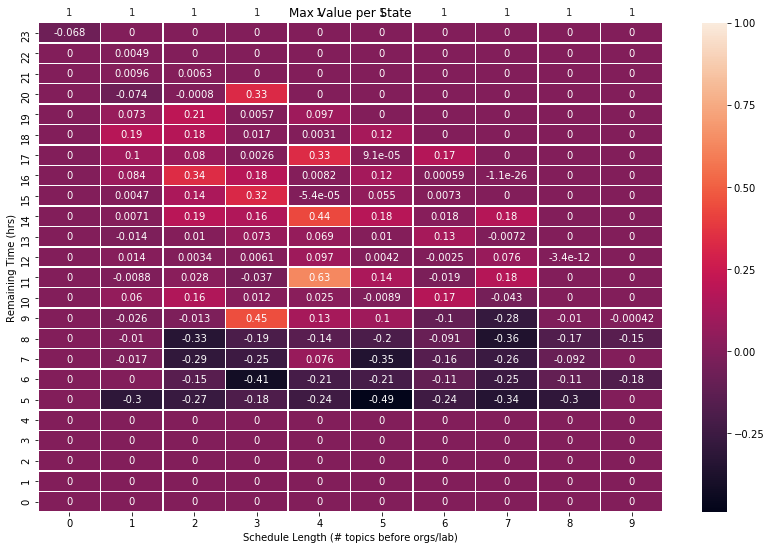

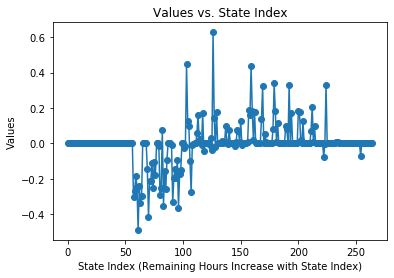

PRIOR TO ORGS/LAB:
Optimal Free Time: 12 HOURS 
Optimal Schedule Length (without Orgs/Lab): 4 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

  LAMBDA = 1 


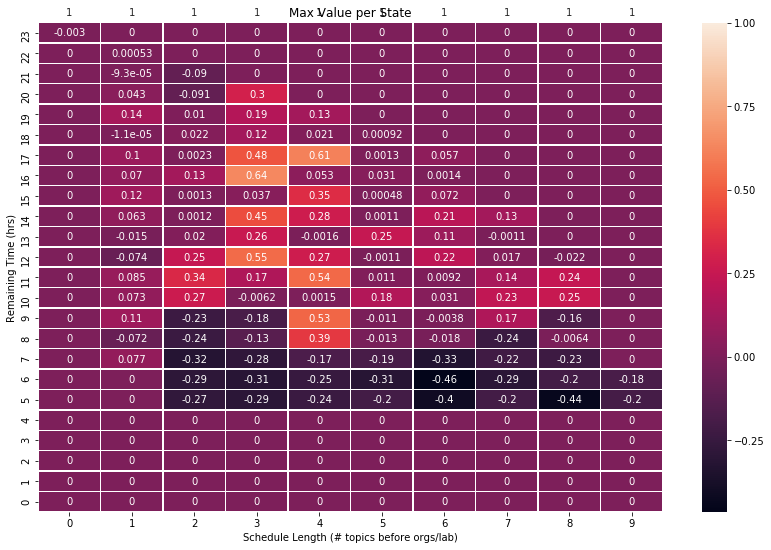

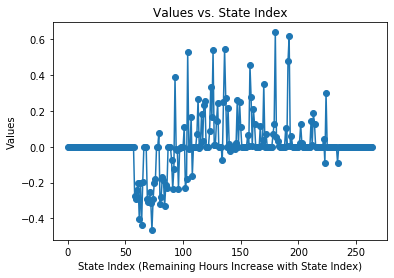

PRIOR TO ORGS/LAB:
Optimal Free Time: 17 HOURS 
Optimal Schedule Length (without Orgs/Lab): 3 COMMITMENTS
FACTORING IN ORGS/LAB:
Optimal Schedules:

Partially Optimal Schedules:
---------------------------------------

CPU times: user 1h 43min 34s, sys: 1min 16s, total: 1h 44min 51s
Wall time: 1h 43min 21s


In [ ]:
%%time 
gamma = 0.5 #1.0 
lmbdas = [0,0.5,0.75,1]
epsilon = 0.1
alpha = 0.1
init = 'arb'
inits = [0.1, 'arb', 'zeros']

num_eps = 100000 # number of runs/eps

TD_init_values = []
TD_init_eps = []
TD_init_ep_rewards = []
TD_init_opt_actions = []

for init in inits:
    print("\033[1;38m  INIT VALUES as {} \033[0m".format(init))
    for lmbda in lmbdas:
        print("\033[1;43m  LAMBDA = {} \033[0m".format(lmbda))

        values, all_episodes, all_episode_rewards = TD(init, lmbda, num_eps)
        optimal_actions = get_opt_actions("TD", values)
        
        TD_init_values.append(values)
        TD_init_eps.append(all_episodes)
        TD_init_ep_rewards.append(all_episode_rewards)
        TD_init_opt_actions.append(optimal_actions)
        
        #plot stuff
        plot_heatmap(values)
        plot_values_actions_states("TD", values)
        if np.argmax(values) != 0:
            best_r_time, best_len = pos_states[np.argmax(values)]
            print("PRIOR TO ORGS/LAB:")
            print("Optimal Free Time: {} HOURS \nOptimal Schedule Length (without Orgs/Lab): {} COMMITMENTS".format(best_r_time, best_len))


        # returns schedules that are EITHER the optimal length or optimal, get unique entries
        optimal_schedules, part_optimal_schds, opt_schd_rewards, part_opt_rewards = get_opt_schedules(values, all_episodes, optimal_actions)
        optimal_schedules = [dict(entry) for entry in set(frozenset(schd.items()) for schd in optimal_schedules)]
        part_optimal_schds = [dict(entry) for entry in set(frozenset(schd.items()) for schd in part_optimal_schds)]

        print("FACTORING IN ORGS/LAB:")
        print("Optimal Schedules:")
        for indx, schd in enumerate(optimal_schedules):
            print(schd, "| Fulfillment:", opt_schd_rewards[indx])
        
        print()
        if optimal_schedules == []:
            print("Partially Optimal Schedules:")
            for indx, schd in enumerate(part_optimal_schds):
                print(schd, "| Fulfillment:", part_opt_rewards[indx])
        print("---------------------------------------\n")
        sys.stdout.flush()

## Save Variables

In [ ]:
with open('TD_init_values.pickle', 'wb') as td_results1:
    pickle.dump(TD_init_values, td_results1)
with open('TD_init_eps.pickle', 'wb') as td_results2:
    pickle.dump(TD_init_eps, td_results2)
with open('TD_init_ep_rewards.pickle', 'wb') as td_results3:
    pickle.dump(TD_init_ep_rewards, td_results3)


In [ ]:
with open('functions.pickle', 'wb') as functions:
    pickle.dump([quick_check, 
                get_opt_actions, 
                calc_V_star, 
                plot_values_actions_states, 
                plot_heatmap, 
                get_opt_schedules], functions)

In [ ]:
optimal_schedules = []
part_optimal_schedules =  []

optimal_schd_rewards = []
part_opt_schd_rewards = []

for state_indx, action in enumerate(optimal_actions):
    if action == 7:

        for episode in all_episodes:
            state, action, reward, schedule = episode[-1]

            if len(schedule) > 2 and "LabStuff" in schedule:
                if state == pos_states[np.argmax(V_star)]:
                    optimal_schedules.append(schedule)
                    optimal_schd_rewards.append(reward)

                elif state[0] == pos_states[np.argmax(V_star)][0] or state[1] == pos_states[np.argmax(V_star)][1]:
                    part_optimal_schedules.append(schedule)
                    part_opt_schd_rewards.append(reward)
